# **cephalometry project:**
## **2D cephalometry landmark localization with FCN heatmap prediction**





# Step 1 : Auxiliary steps

 importing essential python libraries

In [0]:
%matplotlib inline
import cv2
import sys
import tensorflow as tf
import numpy as np
import skimage.io as io
import os
from sklearn.model_selection import train_test_split
from math import*
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *
import keras
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from scipy.ndimage.interpolation import zoom
from scipy.stats import multivariate_normal

# Step 2 : Creating dataset

Generate Heatmap

In [0]:
def cal_sigma(dmax, edge_value):
    return sqrt(- pow(dmax, 2) / log(edge_value))

def gaussian(array_like_hm, mean, sigma):
    """modified version normal distribution pdf, vector version"""
    array_like_hm -= mean
    x_term = array_like_hm[:, 0] ** 2
    y_term = array_like_hm[:, 1] ** 2
    exp_value = - (x_term + y_term) / 2 / pow(sigma, 2)
    return np.exp(exp_value)

def draw_heatmap(width, height, x, y, sigma, array_like_hm):
    m1 = (x, y)
    s1 = np.eye(2) * pow(sigma, 2)
    # k1 = multivariate_normal(mean=m1, cov=593.109206084)
    k1 = multivariate_normal(mean=m1, cov=s1)
    #     zz = k1.pdf(array_like_hm)
    zz = gaussian(array_like_hm, m1, sigma)
    img = zz.reshape((height, width))
    return img

def test(width, height, x, y, array_like_hm):
    dmax = 100
    edge_value = 0.01
    sigma = cal_sigma(dmax, edge_value)

    return draw_heatmap(width, height, x, y, sigma, array_like_hm)

Create Dataset

In [0]:
xres = 480
yres = 544
x = np.arange(xres, dtype=np.float)
y = np.arange(yres, dtype=np.float)
xx, yy = np.meshgrid(x, y)

# evaluate kernels at grid points
xxyy = np.c_[xx.ravel(), yy.ravel()]

#create dataset
train=[]
heatmap=[]
label=[]
for i in range(1,301):
    img = io.imread(os.path.join("drive/My Drive/2d_heatmap/RawImage/TrainingData", "%d_crop.bmp" % i),)
    img=img[0:2176,:]
    img = zoom(img, zoom=0.25, order=1)
    train.append(img)

for j in range(1,301):
    f = open(os.path.join("drive/My Drive/Cephalometry_2d_final/400_senior", "%d.txt" % j))
    fp = open(os.path.join("drive/My Drive/Cephalometry_2d_final/400_junior", "%d.txt" % j))
    line=f.readlines()
    linep=fp.readlines()
    py=(int(line[8].split(',')[1])+int(linep[8].split(',')[1])-200)//8
    px=(int(line[8].split(',')[0])+int(linep[8].split(',')[0]))//8
    coordinate=np.array([px,py])
    imga = test(xres, yres, px, py, xxyy.copy())
    heatmap.append(imga)
    label.append(coordinate)
X_train=np.array(train)
Y_train=np.array(heatmap)
z_train=np.array(label)


# Step 3 :Train-Test split


In [0]:
X_train=np.expand_dims(X_train,axis=3)
Y_train=np.expand_dims(Y_train,axis=3)
x_train, x_test, y_train, y_test =train_test_split(X_train,Y_train, test_size=0.2, random_state=666)
x_train, x_test, z_train, z_test =train_test_split(X_train,z_train, test_size=0.2, random_state=666)
x_train, x_validate, y_train, y_validate =train_test_split(x_train,y_train, test_size=0.25, random_state=666)


Check the shape of dataset

In [18]:
print(x_train.shape)#shape of original image
print(y_test.shape)#shape of heatmaps
print(z_test.shape)#shape of coordinates


(180, 544, 480, 1)
(60, 544, 480, 1)
(60, 2)


# Step 4 : Define the model

#U-net



In [0]:
inputs = tf.keras.layers.Input((544,480,1))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)
 
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)
 
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(c5)
 
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(c9)
 
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
 
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Step 5 : Training


In [21]:
epochs = 50
batch_size = 3
history = model.fit(x_train,y_train, batch_size=batch_size,epochs = epochs, validation_data = (x_validate,y_validate),verbose = 1)

Train on 180 samples, validate on 60 samples
Epoch 1/50
180/180 [==============================] - 6s 32ms/sample - loss: 0.1485 - acc: 9.7869e-07 - val_loss: 0.1211 - val_acc: 1.9148e-06
Epoch 2/50
180/180 [==============================] - 5s 27ms/sample - loss: 0.1000 - acc: 2.9573e-06 - val_loss: 0.0985 - val_acc: 3.8297e-06
Epoch 3/50
180/180 [==============================] - 5s 27ms/sample - loss: 0.0844 - acc: 3.7020e-06 - val_loss: 0.1050 - val_acc: 3.8297e-06
Epoch 4/50
180/180 [==============================] - 5s 27ms/sample - loss: 0.0788 - acc: 3.7233e-06 - val_loss: 0.0952 - val_acc: 3.8297e-06
Epoch 5/50
180/180 [==============================] - 5s 26ms/sample - loss: 0.0744 - acc: 3.7871e-06 - val_loss: 0.0866 - val_acc: 3.7658e-06
Epoch 6/50
180/180 [==============================] - 5s 26ms/sample - loss: 0.0729 - acc: 3.7871e-06 - val_loss: 0.1673 - val_acc: 3.8297e-06
Epoch 7/50
180/180 [==============================] - 5s 26ms/sample - loss: 0.0723 - acc: 3.8084

# Step 6 : History visulization


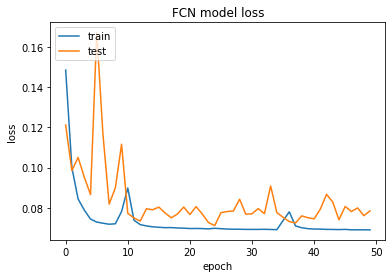

In [28]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('FCN model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Step 7: Evaluation



coordinate label of the first sample: [304 486]
coordinate prediction of the first sample: [309, 486]


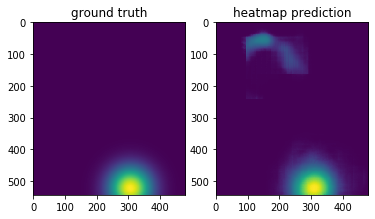

overall mean distance error is 3.8953793941626627


In [30]:
#get mean euclidean distance
def mean_euclidean_distance(gt,prediction):
  store=[]
  error=gt-prediction
  for i in range(z_test.shape[0]):
    distance=np.sqrt(np.sum(np.square(error[i])))
    store.append(distance)
  s=np.array(store)
  return np.mean(s)
    
#evaluation
result=model.predict(x_test)
result=np.squeeze(result, axis=(3,))
gt=np.squeeze(y_test, axis=(3,))
a=result[0,:,:]
print("coordinate label of the first sample:",z_test[1])
landmark=[int(np.where(b==np.max(b))[1]),int(np.where(b==np.max(b))[0])]
print("coordinate prediction of the first sample:",landmark)

#plot some examples
plt.subplot(1,2,1)
plt.imshow(gt[0])
plt.title("ground truth")
plt.subplot(1,2,2)
plt.imshow(a)
plt.title("heatmap prediction")
plt.show()

#overall mean distance error
predict=[]
for i in range(result.shape[0]):
  landmarks=[int(np.where(result[i,:,:]==np.max(result[i,:,:]))[1]),int(np.where(result[i,:,:]==np.max(result[i,:,:]))[0])]
  predict.append(landmarks)
prediction=np.array(predict)
r=mean_euclidean_distance(z_test,prediction)
print("overall mean distance error is",str(r))
